In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import *

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from glob import glob

In [5]:
train_dir = r'/kaggle/input/bird-species-classification-220-categories/Train/'
test_dir = r'/kaggle/input/bird-species-classification-220-categories/Test/'

## Generation of new img

In [7]:
train_gen = ImageDataGenerator(rescale=1./255, rotation_range = 20,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                vertical_flip = True)

test_gen = ImageDataGenerator(rescale=1./255)



In [19]:
n_dim = 200
bs = 30
train_data = train_gen.flow_from_directory(train_dir, batch_size=bs, target_size = (n_dim, n_dim), class_mode = "categorical", shuffle=True)
test_data = test_gen.flow_from_directory(test_dir, batch_size=bs, target_size = (n_dim, n_dim), class_mode = "categorical")

Found 9414 images belonging to 200 classes.
Found 2374 images belonging to 200 classes.


In [20]:
def build_model(num_classes=200, shape=(n_dim,n_dim,3)):
    inputs = tf.keras.layers.Input(shape=shape)
    

    model = EfficientNetB1(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None)
    
    model.trainable = True
    
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    top_dropout_rate = 0.33
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNetB1")
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    
    initial_learning_rate = 1e-3
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

In [21]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True, start_from_epoch=15)
model = build_model()
history = model.fit(train_data, validation_data = test_data, callbacks = [early_stop], epochs = 40,)

Epoch 1/40
314/314 ━━━━━━━━━━━━━━━━━━━━ 367s 759ms/step - accuracy: 0.1066 - loss: 4.8550 - val_accuracy: 0.0080 - val_loss: 5.9908
Epoch 2/40
314/314 ━━━━━━━━━━━━━━━━━━━━ 110s 344ms/step - accuracy: 0.4343 - loss: 2.2417 - val_accuracy: 0.1500 - val_loss: 4.2345
Epoch 3/40
314/314 ━━━━━━━━━━━━━━━━━━━━ 111s 345ms/step - accuracy: 0.5686 - loss: 1.5799 - val_accuracy: 0.4958 - val_loss: 2.0442
Epoch 4/40
314/314 ━━━━━━━━━━━━━━━━━━━━ 111s 345ms/step - accuracy: 0.6636 - loss: 1.2147 - val_accuracy: 0.5219 - val_loss: 2.2750
Epoch 5/40
314/314 ━━━━━━━━━━━━━━━━━━━━ 144s 353ms/step - accuracy: 0.7099 - loss: 1.0434 - val_accuracy: 0.5922 - val_loss: 1.7718
Epoch 6/40
314/314 ━━━━━━━━━━━━━━━━━━━━ 113s 353ms/step - accuracy: 0.7439 - loss: 0.8806 - val_accuracy: 0.5594 - val_loss: 1.8467
Epoch 7/40
314/314 ━━━━━━━━━━━━━━━━━━━━ 112s 348ms/step - accuracy: 0.7576 - loss: 0.8284 - val_accuracy: 0.5981 - val_loss: 1.8644
Epoch 8/40
314/314 ━━━━━━━━━━━━━━━━━━━━ 111s 346ms/step - accuracy: 0.7748 -

## Saving Model

In [31]:
import os
import subprocess
from IPython.display import FileLink, display

In [32]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [33]:
download_file('/kaggle/working/', 'birds_200_efb1_3014.h5')

/kaggle/working/birds_200_efb1_3014.h5.zip

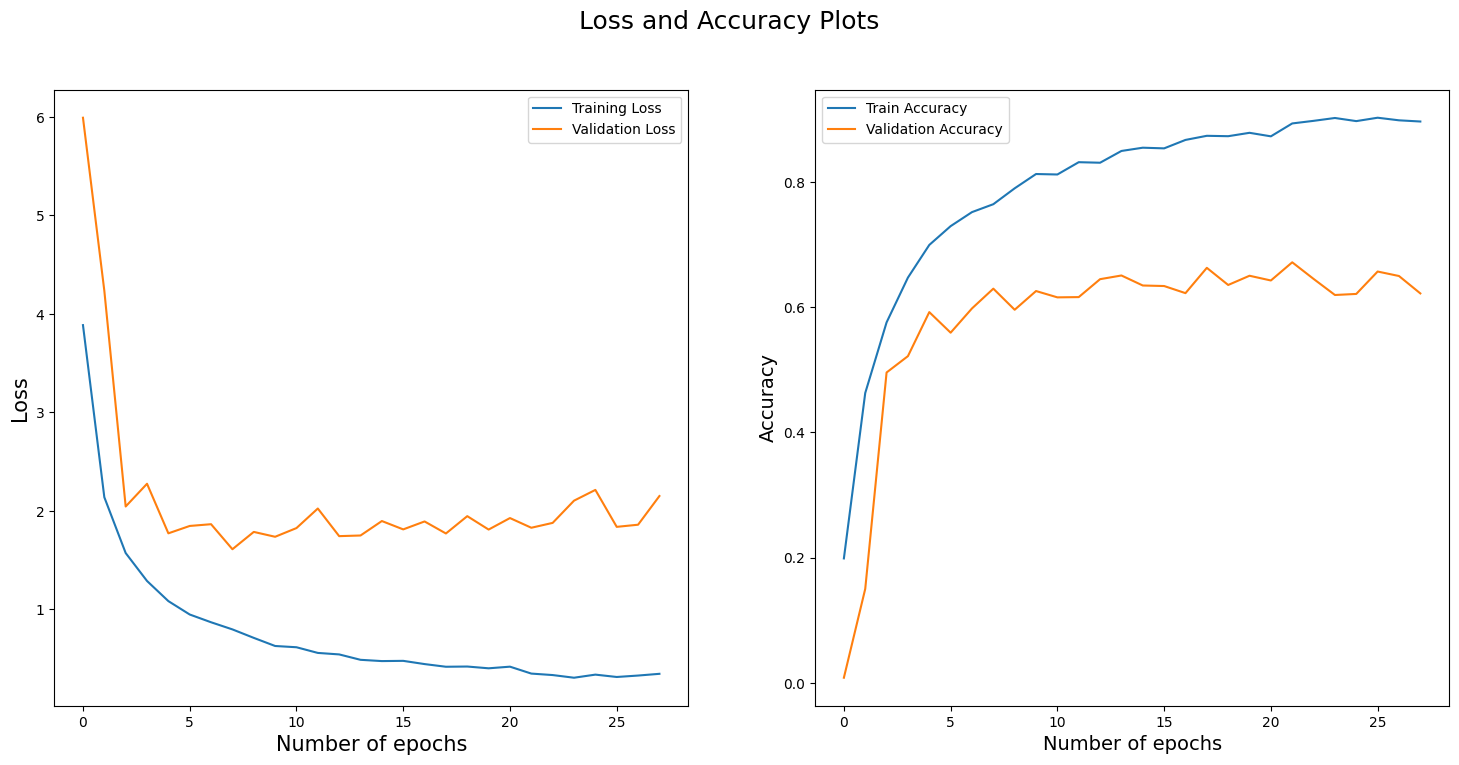

In [35]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [40]:
pip freeze

absl-py==1.4.0
accelerate==0.34.2
aiobotocore==2.15.1
aiofiles==22.1.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1713964853148/work
aioitertools==0.12.0
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
aiosqlite==0.20.0
albucore==0.0.17
albumentations==1.4.17
alembic==1.13.3
altair==5.4.1
annotated-types @ file:///home/conda/feedstock_root/build_artifacts/annotated-types_1716290248287/work
annoy==1.17.3
ansicolors==1.1.8
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1717693030552/work
apache-beam==2.46.0
appdirs==1.4.4
archspec @ file:///home/conda/feedstock_root/build_artifacts/archspec_1708969572489/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1695386546427/work
array_record==0.5.1
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_16961289